# Generative Adversarial Networks (GANs)

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# This part is necessary, otherwise when a matplotlib command is executed a 'kernel died' error is taken and execution stops.
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch

from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

from torch.optim import Adam

torch.manual_seed(0) # Set for testing purposes, please do not change!

from tqdm.auto import tqdm

In [2]:
def show_tensor_images(generated_image_tensor, real_image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    
    image_unflat = generated_image_tensor.detach().cpu().view(-1, *size)
    image_grid_generated = make_grid(image_unflat[:num_images], nrow=5)
    
    image_unflat = real_image_tensor.detach().cpu().view(-1, *size)
    image_grid_real = make_grid(image_unflat[:num_images], nrow=5)
    
    
    fig, axes = plt.subplots(1,2, figsize=(5,2))
    axes[0].imshow(image_grid_generated.permute(1, 2, 0).squeeze())
    axes[1].imshow(image_grid_real.permute(1, 2, 0).squeeze())
    axes[0].title.set_text('Generated')
    axes[1].title.set_text('Real')
    plt.show()

## Load MNIST Data

In [3]:
batch_size = 128

#Load MNIST dataset as tensors
MNIST_loader = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()),
                          batch_size=batch_size, shuffle=True)

It is always good to know what we are working with so a subset of the MNIST data will be shown here.

Image shape torch.Size([1, 28, 28])


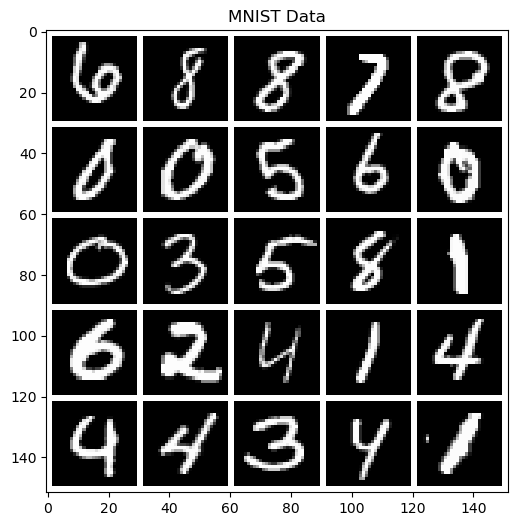

In [4]:
num_imgs_to_visualize = 25  # number of images we'll display
batch = next(iter(MNIST_loader))  # take a single batch from the dataset
img_batch = batch[0]  # extract only images and ignore the labels (batch[1])
img_batch_subset = img_batch[:num_imgs_to_visualize]  # extract only a subset of images

print(f'Image shape {img_batch_subset.shape[1:]}')  # we ignore shape[0] - number of imgs in batch.

grid = make_grid(img_batch_subset, nrow=int(np.sqrt(num_imgs_to_visualize)), normalize=True, pad_value=1.)
grid = np.moveaxis(grid.numpy(), 0, 2)  # from CHW -> HWC format that's what matplotlib expects! Get used to this.

plt.figure(figsize=(6, 6))
plt.imshow(grid)
plt.title("MNIST Data")
plt.show()


## Generator Network

In [5]:
def gen_block(dim_in, dim_out):
    block=nn.Sequential(nn.Linear(dim_in, dim_out),
                        nn.BatchNorm1d(dim_out),
                        nn.ReLU(inplace=True))
    
    return block

In [6]:
class GeneratorNetwork(nn.Module):

    def __init__(self, noise_dim=10, im_dim=784, hidden_dim=128):
        super(GeneratorNetwork, self).__init__()
        
        self.gen = nn.Sequential(gen_block(noise_dim, 256),
                                 gen_block(256, 512),
                                 gen_block(512, 1024),
                                 #gen_block(hidden_dim * 4, hidden_dim * 8)
            
                                 
                                 #gen_block(noise_dim, hidden_dim),
                                 #gen_block(hidden_dim, hidden_dim * 2),
                                 #gen_block(hidden_dim * 2, hidden_dim * 4),
                                 #gen_block(hidden_dim * 4, hidden_dim * 8),
                                 
                                 
            
                                 #nn.Linear(hidden_dim * 8, im_dim),
                                 nn.Linear(1024, im_dim),
                                 nn.Sigmoid())
    def forward(self, noise):
        
        return self.gen(noise)

In [7]:
def get_latent_vector(n_samples, dim_latent, device='cpu'):
    
    return torch.randn(n_samples, dim_latent, device=device)

## Discriminator Network

In [8]:
def disc_block(dim_in, dim_out):
    block=nn.Sequential(nn.Linear(dim_in, dim_out),
                        nn.LeakyReLU(negative_slope=0.2))
    return block

In [9]:
class DiscriminatorNetwork(nn.Module):
    def __init__(self, im_dim=784, hidden_dim=128):
        super(DiscriminatorNetwork, self).__init__()
        
        self.disc = nn.Sequential(disc_block(im_dim, 512),
                                  disc_block(512, 256),
                                  disc_block(256, 128),
                                  disc_block(128, 64),
                                  
                                  #disc_block(im_dim, hidden_dim * 4),
                                  #disc_block(hidden_dim * 4, hidden_dim * 2),
                                  #disc_block(hidden_dim * 2, hidden_dim),
                                  
                                  
                                  
                                  #nn.Linear(hidden_dim, 1))
                                  nn.Linear(64, 1))

    def forward(self, image):
        
        return self.disc(image)

## Training the Model

In [ ]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

n_epochs = 200
#dim_latent = 64
dim_latent = 100
display_step = 500
#lr = 0.00001
lr = 0.0001

# Add GPU as processing device if available, otherwise CPU.
if torch.cuda.is_available() == True:
    proc_dev = 'cuda'
else:
    proc_dev = 'cpu'

adv_loss = nn.BCEWithLogitsLoss() #adversarial loss
real_gt = torch.ones((batch_size, 1), device=proc_dev)
fake_gt = torch.zeros((batch_size, 1), device=proc_dev)

gen = GeneratorNetwork(dim_latent).to(proc_dev)
gen_opt = Adam(gen.parameters(), lr=lr)
disc = DiscriminatorNetwork().to(proc_dev) 
disc_opt = Adam(disc.parameters(), lr=lr)

for epoch in range(n_epochs):
    
    print('Epoch: ', epoch+1, '/',n_epochs)
  
    # Dataloader returns the batches
    for real, _ in tqdm(MNIST_loader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(proc_dev)
        
        # Train discriminator network.
        disc_opt.zero_grad()
        
        fake_images = gen(get_latent_vector(cur_batch_size, dim_latent, device=proc_dev))
        fake_images_predictions = disc(fake_images.detach())
        fake_discriminator_loss = adv_loss(fake_images_predictions, torch.zeros_like(fake_images_predictions))
        real_discriminator_loss = adv_loss(disc(real), torch.ones_like(disc(real)))
        disc_loss = 1/2*(real_discriminator_loss + fake_discriminator_loss)
        
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        
        # Train generator network.
        gen_opt.zero_grad()
        
        gen_pred = disc(gen(get_latent_vector(cur_batch_size, dim_latent, device=proc_dev)))
        gen_loss = adv_loss(gen_pred, torch.ones_like(gen_pred))
        
        gen_loss.backward(retain_graph=True)
        gen_opt.step()


        mean_discriminator_loss += disc_loss.item() / display_step
        mean_generator_loss += gen_loss.item() / display_step
        
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_latent_vector(cur_batch_size, dim_latent, device=proc_dev)
            generated = gen(fake_noise)
            show_tensor_images(generated, real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
                
        cur_step += 1
        

In [11]:
model_path = os.path.join(os.getcwd(), 'models') 

if not os.path.exists(model_path):
    os.makedirs(model_path)

torch.save(gen, os.path.join(model_path, 'GAN_model.pth'))

In [12]:
gen_loaded = torch.load(os.path.join(os.getcwd(), 'models', 'GAN_model.pth'))

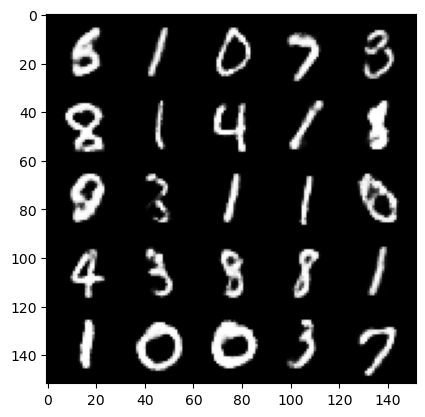

In [13]:
fake_noise = get_latent_vector(cur_batch_size, dim_latent, device=proc_dev)
fake = gen_loaded(fake_noise)

image_size=(1, 28, 28)
image_unflat = fake.detach().cpu().view(-1, *image_size)
image_grid = make_grid(image_unflat[:25], nrow=5)

plt.figure()
plt.imshow(image_grid.permute(1, 2, 0).squeeze())
plt.show()